#### From this book, about page 920: http://hagan.okstate.edu/NNDesign.pdf

#### Perform non-linear regression against a small dataset of 67 records

In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sys
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

L1_SIZE        = 15            # How many nodes in layer 1
EPOCHS         = 2000
TEST_PCT       = 0.30
VAL_PCT        = 0.10
FEATURE_COUNT  = 2
BATCH_SIZE     = 12
LEARNING_RATE  = .001
SUMMARIES_DIR  = '/home/tom/tf_logs' # where to store Tensorboard data
L2             = True
LAMBDA         = 0.2              # Regularization parameter
DROPOUT_KEEP   = 1.0
PLOT           = False
SYNTHETIC      = False

#### Get the data

In [22]:
if sys.platform[:3] =='win':
    data_loc = 'D:/Data/'
else:
    data_loc = "/home/tom/data/"

filenm = "haganCaseStudy1.csv"
df = pd.read_csv(data_loc+filenm, delimiter = ',')

# v1 and v2 is the voltage coming out of the 2 solar cells
# y is the position of the ping pong ball (in front of a light)
before = df.describe()

#### Create some synthetic data so we have good quantity

In [23]:
if SYNTHETIC:
    orig = df.copy()
    for x in range(10):
        df_copy = orig.copy()
        df_copy['v1'] = df_copy['v1'] + np.divide(np.random.randn(),10)
        df_copy['v2'] = df_copy['v2'] + np.divide(np.random.randn(),10)
        df_copy['y'] = df_copy['y'] + np.divide(np.random.randn(),30)
        df = df.append(df_copy)
# Set any negative values to 0
    negs = df['v1']<0
    df['v1'][negs]=0
    negs = df['v2']<0
    df['v2'][negs]=0
    after = df.describe()

In [24]:
# Standardize the data
v1     = df['v1'].values.reshape(-1,1)
v1_std = StandardScaler().fit_transform(v1)
v2     = df['v2'].values.reshape(-1,1)
v2_std = StandardScaler().fit_transform(v2)
y      = df['y'].values.reshape(-1,1)
y_std  = StandardScaler().fit_transform(y)

In [25]:
# Split into train, val and test
# Recombine into DF
arr = np.concatenate([v1_std,v2_std,y_std], axis=1)
cols = ['v1','v2','y']
df = pd.DataFrame(arr, columns=cols)

train, test = train_test_split(df, test_size=TEST_PCT)
train, val  = train_test_split(df, test_size=VAL_PCT)
print('Training:   {:,} rows'.format(train.shape[0]))
print('Validation: {:,} rows'.format(val.shape[0]))
print('Test:       {:,} rows'.format(test.shape[0]))

Training:   60 rows
Validation: 7 rows
Test:       21 rows


In [26]:
train_data   = train[['v1', 'v2']]
train_labels = train[['y']]
val_data     = val[['v1', 'v2']]
val_labels   = val[['y']]
test_data    = test[['v1', 'v2']]
test_labels  = test[['y']]

In [27]:
# See what the data looks like
if PLOT:
    a = plt.scatter(y_std[:2000], v1_std[:2000], s=1, color='blue',label='Voltage1')
    b = plt.scatter(y_std[:2000], v2_std[:2000], s=1, color='red', label='Voltage2')
    plt.legend(loc='lower right')
    plt.xlabel('Position', fontsize=12)
    plt.ylabel('Voltages', fontsize=12)
    plt.show()

In [28]:
# Set up the network
tf.reset_default_graph()
x       = tf.placeholder("float", shape=[None, FEATURE_COUNT])
y_      = tf.placeholder("float", shape=[None, 1])
dropout = tf.placeholder("float")

l1_w   = tf.Variable(tf.truncated_normal([FEATURE_COUNT, L1_SIZE]), dtype=tf.float32)
l1_b   = tf.zeros([1, L1_SIZE])
l1_out = tf.nn.tanh(tf.matmul(x,l1_w) + l1_b)
l1_out = tf.nn.dropout(l1_out, keep_prob=dropout)

l2_w   = tf.Variable(tf.truncated_normal([L1_SIZE, 1]), dtype=tf.float32)
l2_b   = tf.zeros([1,1])
l2_out = tf.matmul(l1_out, l2_w) + l2_b
if L2:
    cost = (tf.reduce_mean(tf.square(l2_out - y_) + LAMBDA * tf.nn.l2_loss(l1_w)))
else:
    cost = tf.reduce_sum(tf.square(l2_out - y_))

# Optimizer
optimize = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(cost)

tf.scalar_summary('cost', cost)

merged = tf.merge_all_summaries()

In [29]:
count = 1
num_training_batches = int(len(train_data) / BATCH_SIZE)

with tf.Session() as sess:
    print('DROPOUT: {:%}'.format(DROPOUT_KEEP))
    print('Regularization is {}'.format(L2))
    train_writer = tf.train.SummaryWriter(SUMMARIES_DIR + '/run3', sess.graph)
    sess.run(tf.initialize_all_variables())
    for i in range(EPOCHS):
        data,labels = shuffle(train_data, train_labels)
        for j in range(num_training_batches):
            x_mini = data[j*BATCH_SIZE:j*BATCH_SIZE+BATCH_SIZE]
            y_mini = labels[j*BATCH_SIZE:j*BATCH_SIZE+BATCH_SIZE]
            sess.run(optimize, feed_dict = {x: x_mini, y_: y_mini, dropout:DROPOUT_KEEP})
        _, s = sess.run([cost, merged], feed_dict = {x: val_data,y_: val_labels, dropout:1.0,})
        if j % 10 == 0:
            train_writer.add_summary(s, count)
            count += 1
    s, preds = sess.run([cost, l2_out], feed_dict = {x: test_data, y_: test_labels, dropout:1.0})
    print('Test set accuracy: {:.3}'.format(s))
    train_writer.close()
    !aplay /usr/share/sounds/bicycle_bell.wav

DROPOUT: 100.000000%
Regularization is True
Test set accuracy: 0.136
Playing WAVE '/usr/share/sounds/bicycle_bell.wav' : Signed 16 bit Little Endian, Rate 11127 Hz, Mono


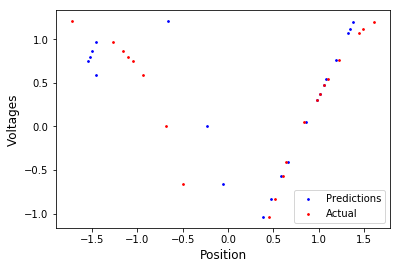

In [30]:
# See what the data looks like
PLOT = True
if PLOT:
    a = plt.scatter(preds, test_data['v2'], s=3, color='blue',label='Predictions')
    b = plt.scatter(test_labels, test_data['v2'], s=3, color='red', label='Actual')
    plt.legend(loc='lower right')
    plt.xlabel('Position', fontsize=12)
    plt.ylabel('Voltages', fontsize=12)
    plt.show()